# Spectrum Analysis

In this example we demonstrate frequency domain analysis using PathSim's spectrum block. We'll examine the frequency response of a Butterworth lowpass filter by analyzing its response to a Gaussian pulse.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_spectrum.py).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import (
    Scope, 
    Spectrum,
    ButterworthLowpassFilter,
    GaussianPulseSource
)
from pathsim.solvers import RKCK54

## System Setup

We'll create a simple signal chain:
1. A Gaussian pulse source with controllable bandwidth
2. A Butterworth lowpass filter
3. Scope and Spectrum blocks to observe time and frequency domain behavior

In [5]:
# Corner frequency of the filter
f = 5

# Blocks that define the system
Src = GaussianPulseSource(f_max=5*f, tau=0.3)
FLT = ButterworthLowpassFilter(f, 10)
Sco = Scope(labels=["pulse", "filtered"])
Spc = Spectrum(freq=np.linspace(0, 2*f, 100), 
               labels=["pulse", "filtered"])

blocks = [Src, FLT, Sco, Spc]

In [7]:
# The connections between the blocks
connections = [
    Connection(Src, FLT, Sco, Spc),
    Connection(FLT, Sco[1], Spc[1])
]

In [9]:
# Initialize simulation
Sim = Simulation(
    blocks, 
    connections, 
    dt=1e-2, 
    log=True, 
    Solver=RKCK54, 
    tolerance_lte_rel=1e-5, 
    tolerance_lte_abs=1e-7
)

2025-10-10 14:09:40,087 - INFO - LOGGING (log: True)
2025-10-10 14:09:40,088 - INFO - BLOCK (type: GaussianPulseSource, dynamic: False, events: 0)
2025-10-10 14:09:40,089 - INFO - BLOCK (type: ButterworthLowpassFilter, dynamic: True, events: 0)
2025-10-10 14:09:40,089 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 14:09:40,089 - INFO - BLOCK (type: Spectrum, dynamic: True, events: 0)
2025-10-10 14:09:40,090 - INFO - GRAPH (size: 4, alg. depth: 1, loop depth: 0, runtime: 0.118ms)


Now let's run the simulation:

2025-10-10 14:09:42,634 - INFO - STARTING -> TRANSIENT (Duration: 3.00s)
2025-10-10 14:09:42,634 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-10 14:09:42,665 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 94 steps (3055.8 steps/s)
2025-10-10 14:09:42,682 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: --:--:--) | 146 steps (3010.9 steps/s)
2025-10-10 14:09:42,691 - INFO - TRANSIENT:  61% | elapsed: 00:00:00 (eta: --:--:--) | 176 steps (3250.0 steps/s)
2025-10-10 14:09:42,697 - INFO - TRANSIENT:  81% | elapsed: 00:00:00 (eta: --:--:--) | 193 steps (3071.9 steps/s)
2025-10-10 14:09:42,701 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: --:--:--) | 204 steps (2595.7 steps/s)
2025-10-10 14:09:42,701 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: --:--:--) | 204 steps (3005.3 avg steps/s)
2025-10-10 14:09:42,702 - INFO - FINISHED -> TRANSIENT (total steps: 204, successful: 174, runtime: 67.88 ms)


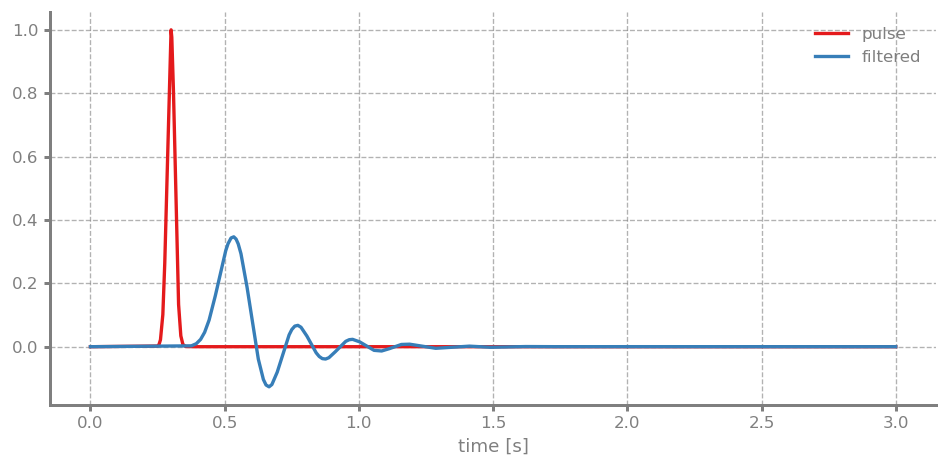

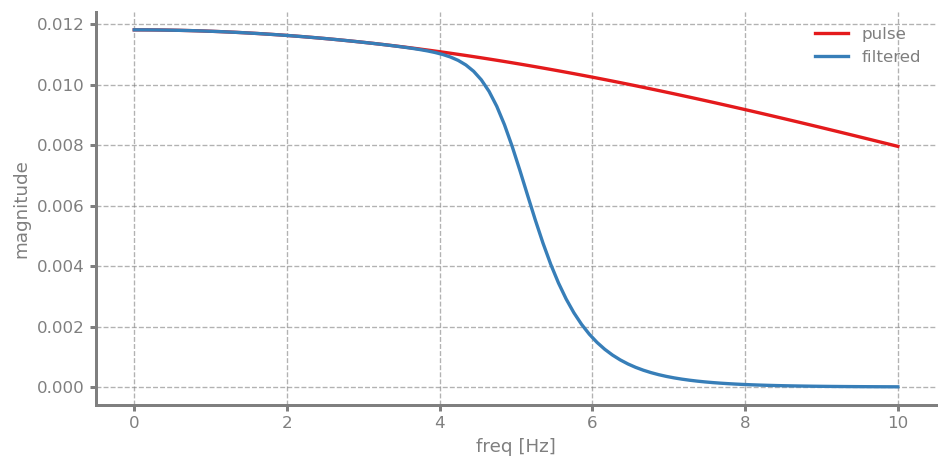

In [12]:
# Run the simulation for some time
Sim.run(3)

# Plot the time domain results
Sco.plot()

# Plot the frequency domain results
Spc.plot()

plt.show()

## Frequency Response Recovery

One powerful feature is that we can recover the frequency response of the filter by taking the ratio of the output spectrum to the input spectrum:

In [15]:
# Recover frequency response from spectrum block
freq, (G_pulse, G_filt) = Spc.read()
H_filt_sim = G_filt / G_pulse

In [17]:
# Ideal frequency response from filter state-space model
def H(s):
    return np.dot(FLT.C, np.linalg.solve((s*np.eye(FLT.n) - FLT.A), FLT.B)) + FLT.D

H_filt_ideal = np.array([H(2j*np.pi*f) for f in freq]).flatten()

Now let's plot the comparison between the recovered and ideal frequency responses:

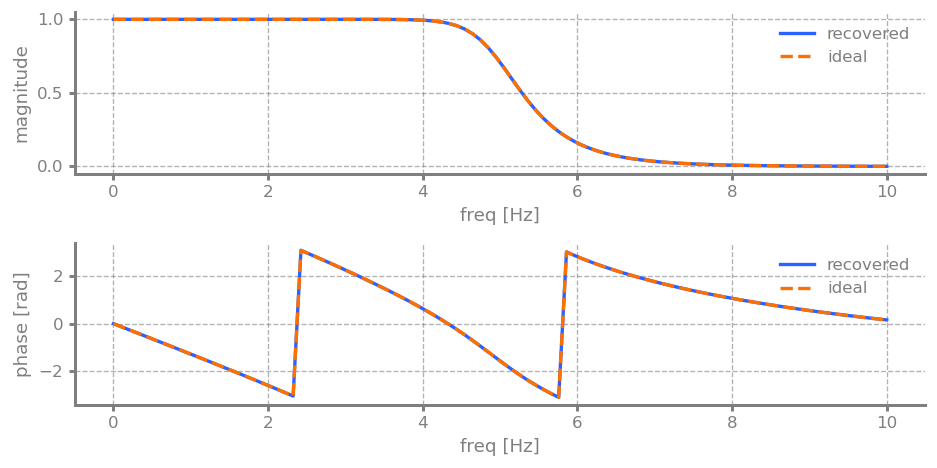

In [22]:
# Plot the frequency domain responses (ideal and recovered)
fig, ax = plt.subplots(nrows=2, tight_layout=True, dpi=120)

ax[0].plot(freq, abs(H_filt_sim), label="recovered")
ax[0].plot(freq, abs(H_filt_ideal), "--", label="ideal")
ax[0].set_xlabel("freq [Hz]")
ax[0].set_ylabel("magnitude")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(freq, np.angle(H_filt_sim), label="recovered")
ax[1].plot(freq, np.angle(H_filt_ideal), "--", label="ideal")
ax[1].set_xlabel("freq [Hz]")
ax[1].set_ylabel("phase [rad]")
ax[1].legend()
ax[1].grid(True)

plt.show()